In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [8]:
# Parameters
S0 = 100          # Initial stock price
K = 100           # Strike price
T = 1             # Time to expiration
r = 0.05          # Risk-free interest rate
sigma = 0.2       # Volatility
steps = 5_000     # Number of time steps
dt = T / steps    # Time step size

In [9]:
# Black-Scholes functions
def black_scholes_call(S, K, T, r, sigma):
    """Calculates Black-Scholes call option price."""
    if T <= 0:
        return np.maximum(0, S - K)  # Handle expiration case
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def black_scholes_delta(S, K, T, r, sigma):
    """Calculates Black-Scholes delta for a call option."""
    if T <= 0:
        return 1.0 if S > K else 0.0 # Handle expiration case
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

In [4]:
# Simulation
np.random.seed(42) # for reproducibility

# Initialize portfolio
portfolio_value = 0.0
cash_account = 0.0
shares_held = 0.0

# 1. Calculate initial option price and delta
initial_option_price = black_scholes_call(S0, K, T, r, sigma)
initial_delta = black_scholes_delta(S0, K, T, r, sigma)

# Set up initial hedge portfolio
shares_held = initial_delta
cash_account = initial_option_price - shares_held * S0
portfolio_value = cash_account + shares_held * S0 # Should be equal to initial_option_price

# Store values for plotting
stock_prices = [S0]
option_prices = [initial_option_price]
portfolio_values = [portfolio_value]
deltas = [initial_delta]
cash_accounts = [cash_account]
shares_held_list = [shares_held]

current_S = S0

In [5]:
# 2. Dynamic Hedging over time steps
for i in range(1, steps + 1):
    time_to_expiry = T - i * dt

    # Simulate stock price movement (Geometric Brownian Motion)
    z = np.random.normal(0, 1) # Standard normal random number
    current_S = current_S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    stock_prices.append(current_S)

    # Recalculate option price and delta
    current_option_price = black_scholes_call(current_S, K, time_to_expiry, r, sigma)
    option_prices.append(current_option_price)
    current_delta = black_scholes_delta(current_S, K, time_to_expiry, r, sigma) # -- Change this part to NN --
    deltas.append(current_delta)

    # Adjust hedge: Calculate change in delta
    delta_change = current_delta - shares_held
    shares_to_trade = delta_change

    # Trade shares and update cash account
    cash_account -= shares_to_trade * current_S  # Buy shares (or sell if negative), cash decreases (or increases)
    shares_held += shares_to_trade

    # Let cash account grow with risk-free rate
    cash_account *= np.exp(r * dt)

    # Update portfolio value
    portfolio_value = cash_account + shares_held * current_S
    portfolio_values.append(portfolio_value)
    cash_accounts.append(cash_account)
    shares_held_list.append(shares_held)

In [6]:
# 3. Expiration Payoff
option_payoff = np.maximum(0, current_S - K)
final_portfolio_value = portfolio_values[-1]

print(f"Initial Black-Scholes Option Price: {initial_option_price:.4f}")
print(f"Final Portfolio Value (Hedge): {final_portfolio_value:.4f}")
print(f"Option Payoff at Expiration: {option_payoff:.4f}")
print(f"Difference between Final Portfolio Value and Option Payoff: {final_portfolio_value - option_payoff:.4f}")

Initial Black-Scholes Option Price: 10.4506
Final Portfolio Value (Hedge): 11.5810
Option Payoff at Expiration: 11.5411
Difference between Final Portfolio Value and Option Payoff: 0.0399


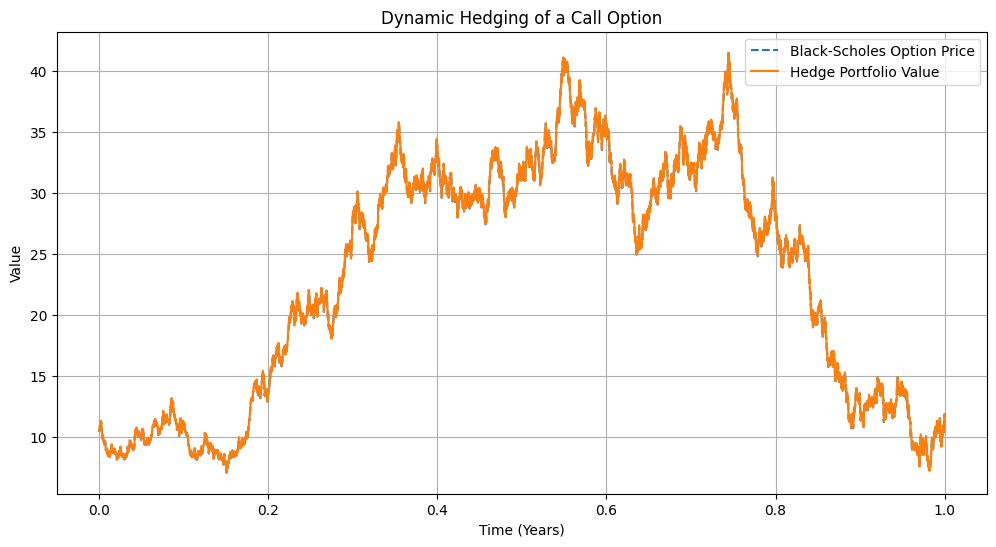

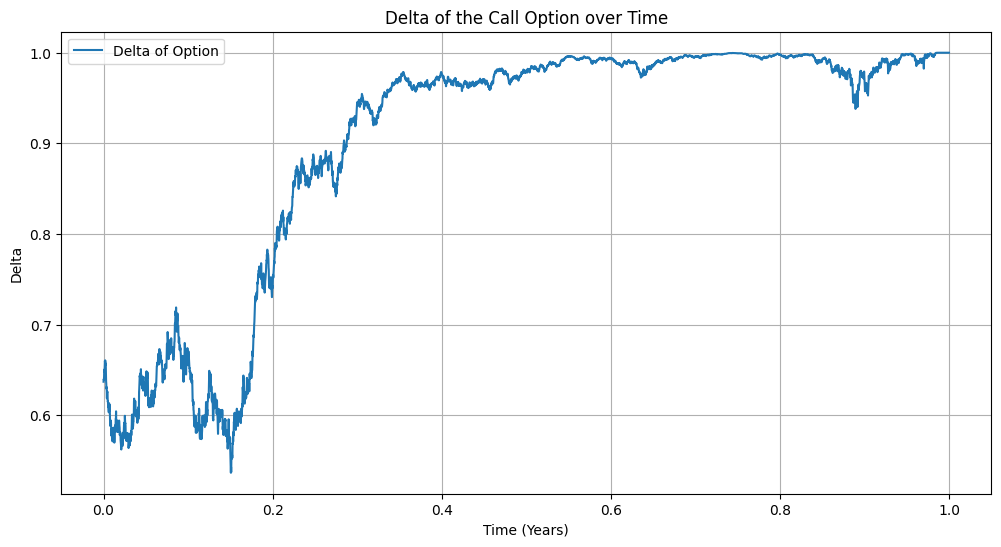

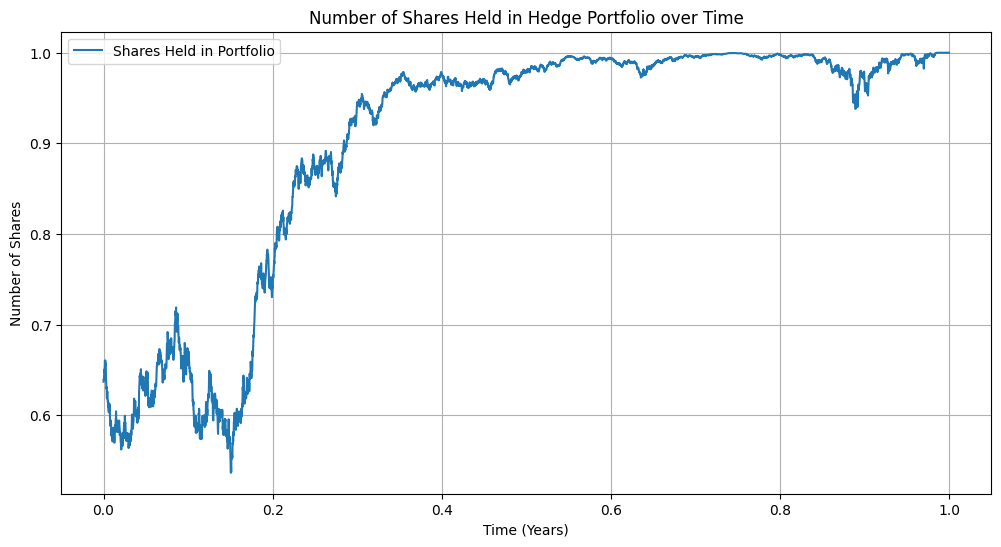

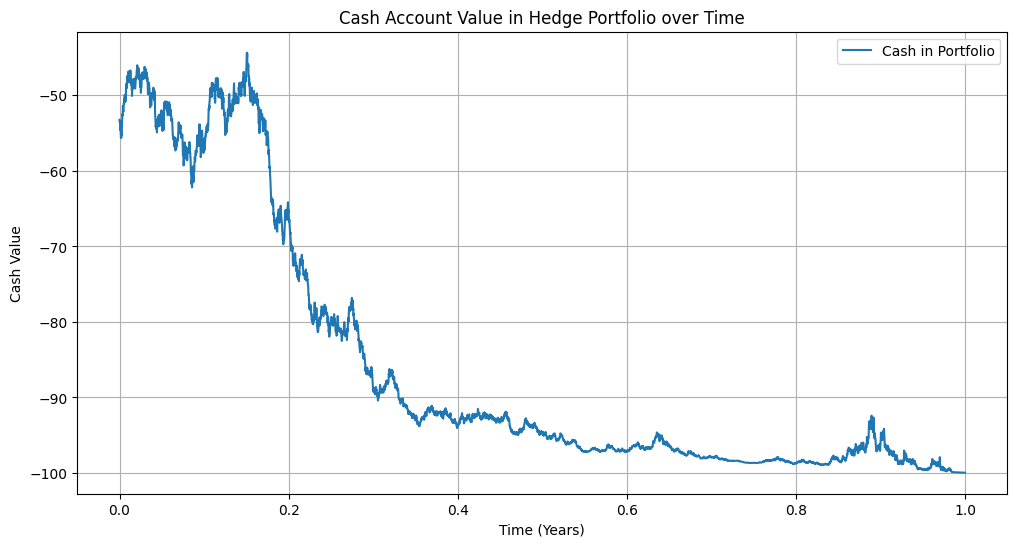

In [7]:
time_axis = np.linspace(0, T, steps + 1)
plt.figure(figsize=(12, 6))
plt.plot(time_axis, option_prices, label='Black-Scholes Option Price', linestyle='--')
plt.plot(time_axis, portfolio_values, label='Hedge Portfolio Value')
plt.xlabel('Time (Years)')
plt.ylabel('Value')
plt.title('Dynamic Hedging of a Call Option')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_axis, deltas, label='Delta of Option')
plt.xlabel('Time (Years)')
plt.ylabel('Delta')
plt.title('Delta of the Call Option over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_axis, shares_held_list, label='Shares Held in Portfolio')
plt.xlabel('Time (Years)')
plt.ylabel('Number of Shares')
plt.title('Number of Shares Held in Hedge Portfolio over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_axis, cash_accounts, label='Cash in Portfolio')
plt.xlabel('Time (Years)')
plt.ylabel('Cash Value')
plt.title('Cash Account Value in Hedge Portfolio over Time')
plt.legend()
plt.grid(True)
plt.show()